In [33]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from nilearn.image import resample_img

import pydra
from pydra.engine.specs import File, SpecInfo
from pydra.engine.core import Workflow
from pydra.engine.task import FunctionTask
import pydra.tasks.ants as ants

from nilearn import plotting
import matplotlib.pyplot as plt

## 04/08/2024

In [27]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
mri_file = os.path.join(data_dir, "original_MRI.nii.gz")
fusi_file = os.path.join(data_dir, "Charmander_withouskull_withMB_3Dscan_4_angio3D.nii")
fusi_chunk_file1 = os.path.join(data_dir, "Grouper_3DAnigio_WithLu_0321_3Dscan_2.nii")
fusi_chunk_file2 = os.path.join(data_dir, "Zion_3Danigio_withLu_0321_2ndtry_3Dscan_5.nii")
output_dir = os.path.join(os.getcwd(), "output")

In [31]:
mri_img = nib.load(mri_file)
mri_img.header.get_zooms()

(0.2, 0.2, 0.2)

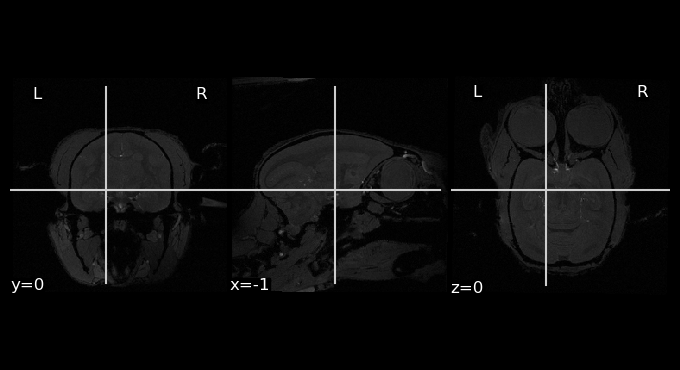

In [22]:
plotting.plot_anat(mri_file)

In [30]:
fusi_img = nib.load(fusi_file)
fusi_img.header.get_zooms()

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(0.11, 0.2, 0.09856)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


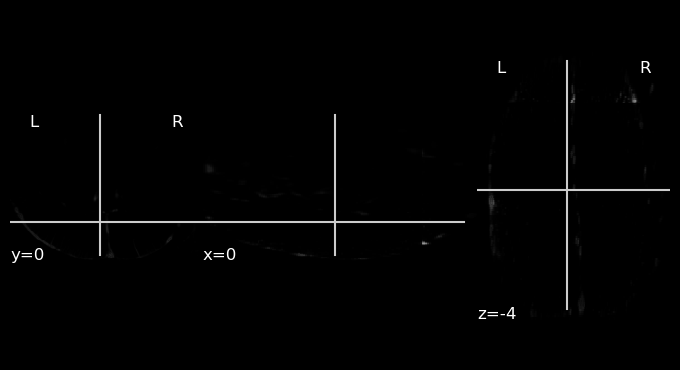

In [24]:
plotting.plot_anat(fusi_file)

In [25]:
fusi_chunk_data1 = nib.load(fusi_chunk_file1).get_fdata()
fusi_chunk_data1.shape

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(128, 36, 153)

In [29]:
fusi_chunk_img2 = nib.load(fusi_chunk_file2)
fusi_chunk_img2.header.get_zooms()

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(0.11, 0.2, 0.09856)

## 04/17/2024

In [16]:
! module load openmind/fsl/5.0.9

In [7]:

from nipype.interfaces.dcm2nii import Dcm2niix
converter = Dcm2niix()
# Set the parameters for the conversion
converter.inputs.source_dir = '/om/user/yibei/fUSi-workflow/data/Florian_raw_data/DICOM'  # Update with the path to your DICOM folder
converter.inputs.compression = 5
converter.inputs.output_dir = '/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti'  # Update with your output path
converter.inputs.out_filename = '%p_%t'  # Format the output filenames

# Run the conversion
result = converter.run()


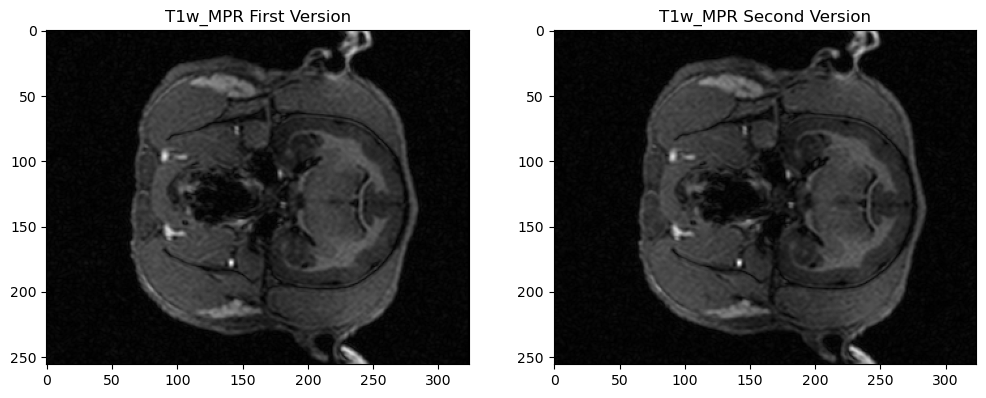

In [9]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the images
img1 = nib.load('/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti/T1w_MPR_20240405094408.nii.gz')
img2 = nib.load('/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti/T1w_MPR_20240405094408a.nii.gz')

# Convert to numpy arrays
data1 = img1.get_fdata()
data2 = img2.get_fdata()

# Display the middle slice of each image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(data1[:, :, data1.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR First Version')
plt.subplot(1, 2, 2)
plt.imshow(data2[:, :, data2.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR Second Version')
plt.show()


In [ ]:
from nipype.interfaces.fsl import BET

# Setting up brain extraction for a T1-weighted image
bet = BET()
bet.inputs.in_file = '/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti/T1w_MPR_20240405094408.nii.gz'
bet.inputs.out_file = '/om/user/yibei/fUSi-workflow/output/Florian_preprocessed/T1w_MPR_brain.nii.gz'
bet.inputs.frac = 0.5  # Fractional intensity threshold, adjust as necessary
bet.inputs.mask = True  # Output a brain mask as well

# Execute the BET command
bet_result = bet.run()


In [17]:
import os
from nipype.interfaces import fsl

print(os.getenv('FSLDIR'))
print(fsl.Info().version())

None
None


In [15]:
from nipype.interfaces.fsl import BET
import matplotlib.pyplot as plt
import nibabel as nib

# Load the MRI image for visual inspection
mri_file = '/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti/T1w_MPR_20240405094408.nii.gz'
mri_img = nib.load(mri_file)
mri_data = mri_img.get_fdata()

# Define a range of potential frac values
frac_values = [0.3, 0.4, 0.5, 0.6, 0.7]

for frac in frac_values:
    # Set up BET for each frac value
    bet = BET(in_file=mri_file, out_file=f"/om/user/yibei/fUSi-workflow/output/Florian_preprocessed/T1w_MPR_brain_{frac}.nii.gz", frac=frac, mask=True)
    # Run BET
    bet.run()
    
    # Load the output mask for visual inspection
    brain_mask = nib.load(f"/om/user/yibei/fUSi-workflow/output/Florian_preprocessed/T1w_MPR_brain_{frac}_mask.nii.gz").get_fdata()

    # Display the middle slice of the brain extraction result
    plt.figure(figsize=(5, 5))
    plt.imshow(mri_data[:, :, mri_data.shape[2] // 2], cmap='gray')
    plt.imshow(brain_mask[:, :, brain_mask.shape[2] // 2], alpha=0.5, cmap='Reds')
    plt.title(f'BET Result with frac = {frac}')
    plt.show()


240417-21:04:56,196 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


OSError: No command "bet" found on host node100. Please check that the corresponding package is installed.